In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
stroke_df  = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

In [3]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- We have seriously imbalanced classes
- Precision/Recall to be used to evaluate the model
- Missing values for BMI

In [5]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
cat_cols = stroke_df.select_dtypes("object").columns.tolist()

In [7]:
for col in cat_cols:
    print("*****************")
    print(stroke_df[col].value_counts())
    print("*****************")

*****************
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
*****************
*****************
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
*****************
*****************
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
*****************
*****************
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
*****************
*****************
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
*****************


In [8]:
stroke_df.stroke.value_counts(normalize=True)

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64

#### Split Train/Test Data

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(stroke_df, test_size=0.2, random_state=42)

In [10]:
X_train.shape

(4088, 12)

<Axes: >

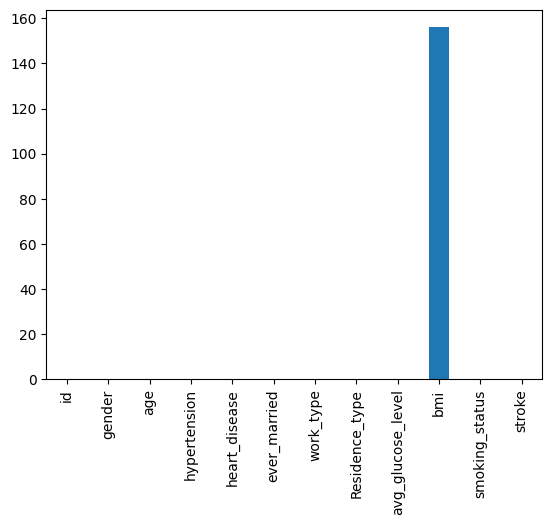

In [11]:
## check for missing values
X_train.isna().sum().plot(kind="bar")

In [12]:
# check for duplicated rows
X_train.duplicated().any()

False

### EDA

In [13]:
# import require libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

params = {
    'figure.figsize': [10, 6],
    'axes.titlesize': 10,
    'axes.labelsize': 8
}

matplotlib.rcParams.update(params)

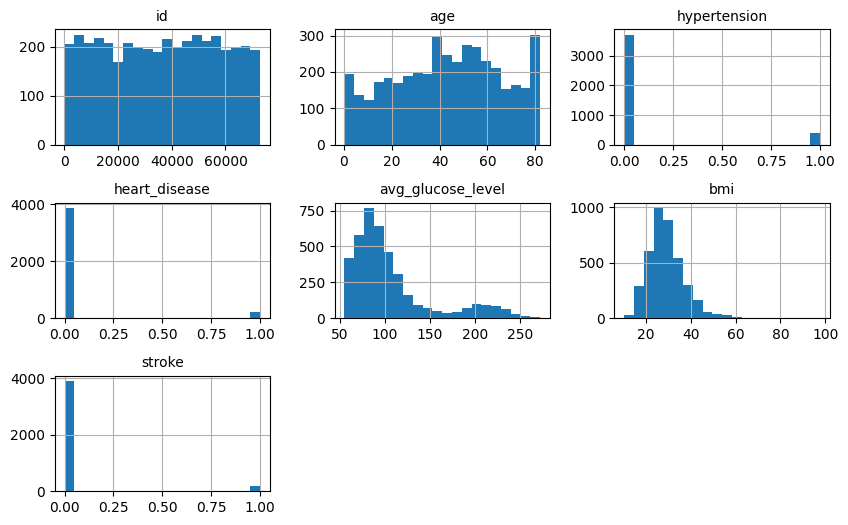

In [14]:
X_train.hist(bins=20)
plt.subplots_adjust(hspace=0.5)
plt.show()

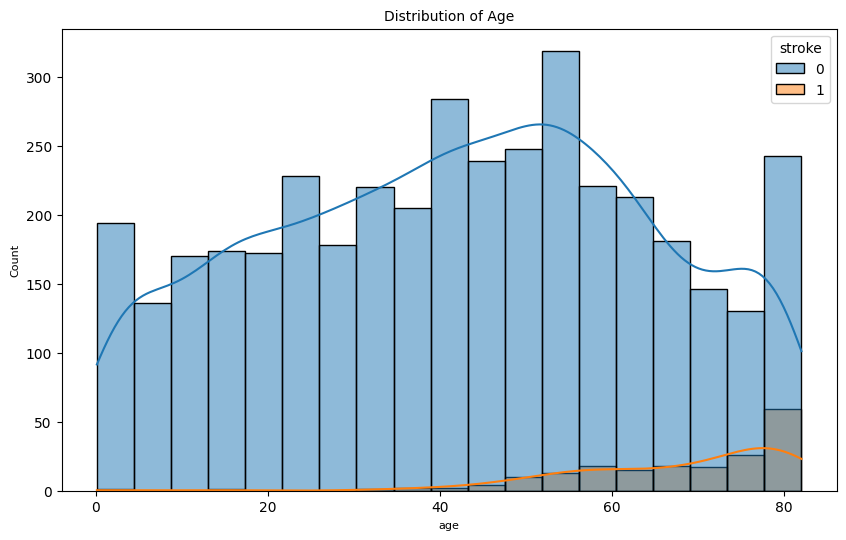

In [15]:
sns.histplot(X_train, x="age", kde=True, hue="stroke")
plt.title("Distribution of Age")
plt.show()

- Although not conclusive, we can see that stroke is more prevalent in patients that are 80 or above
- Patients over 40 are also likely to be diagnosed with stroke, although there could be other causes. We investigate further

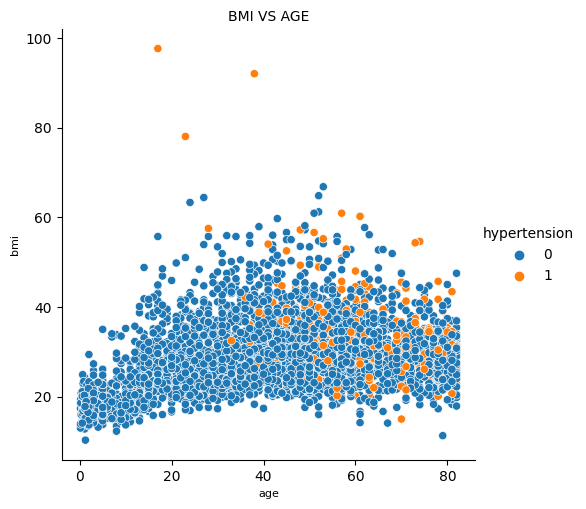

In [16]:
sns.relplot(X_train, x="age", y="bmi", kind="scatter", hue="hypertension")
plt.title("BMI VS AGE")
plt.show()

- Hypertension is more prevalent in older patients
- Patients with very high BMI are prone to hypertension

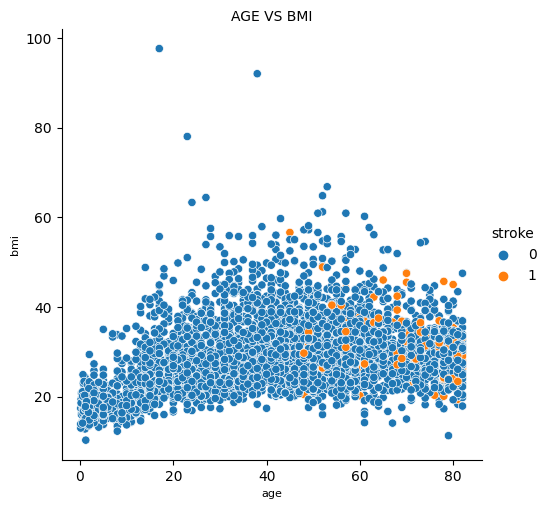

In [17]:
sns.relplot(X_train, x="age", y="bmi", kind="scatter", hue="stroke")
plt.title("AGE VS BMI")
plt.show()

- BMI doesn't seem to have any impact on wether a patient has stroke or not
- As we noticed earlier, Older Patients (with certain other conditions) tend to be diagnosed with stoke

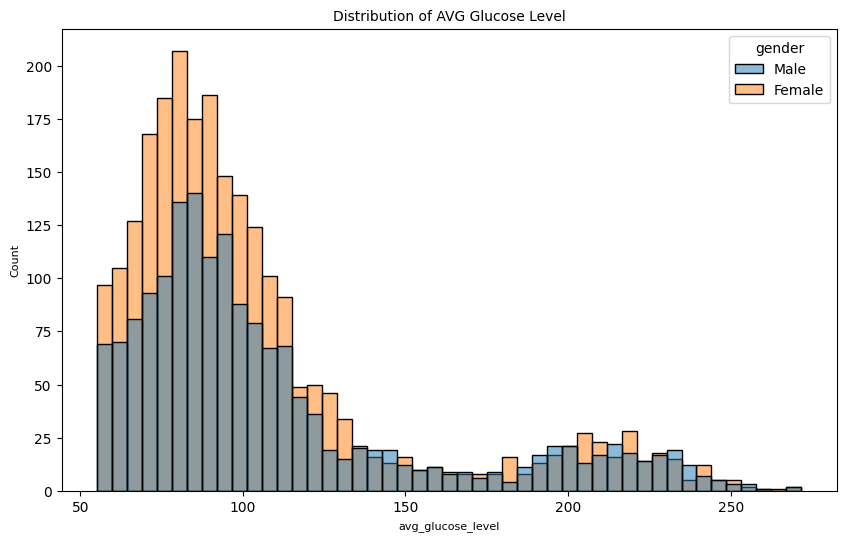

In [18]:
sns.histplot(X_train, x="avg_glucose_level", hue="gender")
plt.title("Distribution of AVG Glucose Level")
plt.show()

- Same distribution for the two gender
- Men generally have higher glucose level than women

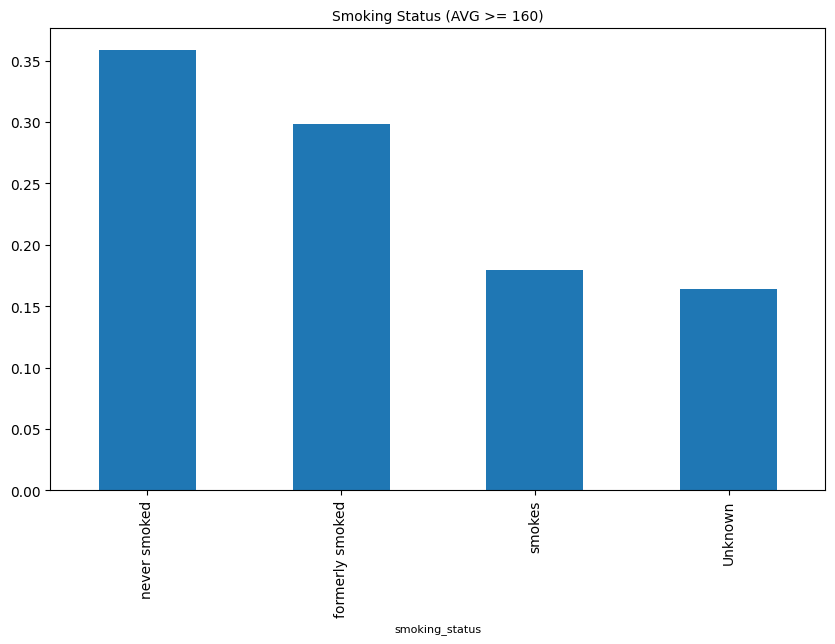

In [19]:
# analyse for avg_glucose_level (diabetes) combination factors
# pre-diabetes > 140, diabetes >= 200

group_data = X_train[(X_train["avg_glucose_level"] >= 150) & X_train["stroke"] == 1]

group_data["smoking_status"].value_counts(normalize=True).plot(kind="bar")
plt.title("Smoking Status (AVG >= 160)")
plt.show()

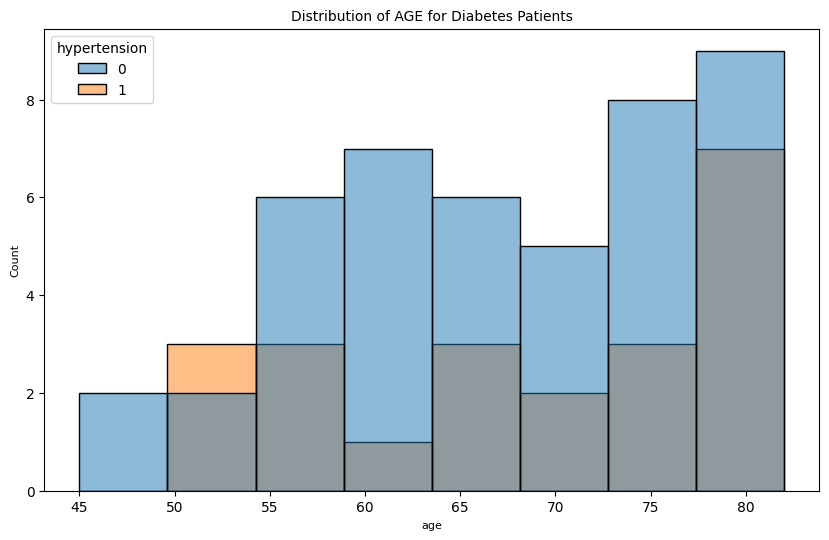

In [20]:
# check for distribution of age
sns.histplot(group_data, x="age", hue="hypertension")
plt.title("Distribution of AGE for Diabetes Patients")
plt.show()

- Our histogram suggests that patients from 45 years with high average glucose level tend to be diagnosed with stroke
- More signicant in much older patients (over 75) that also have hypertension

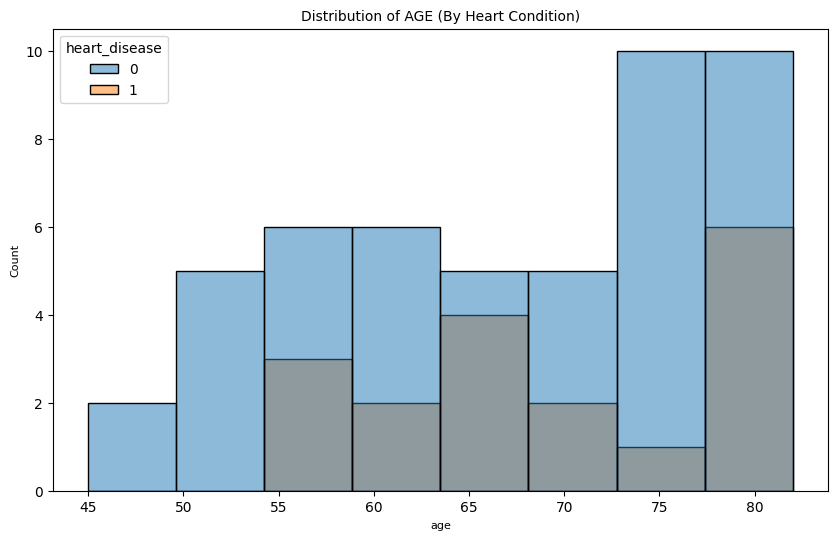

In [21]:
# check for distribution of age
sns.histplot(group_data, x="age", hue="heart_disease")
plt.title("Distribution of AGE (By Heart Condition)")
plt.show()

In [22]:
# Patients with Stroke

stroke_patients = X_train[X_train["stroke"] == 1]

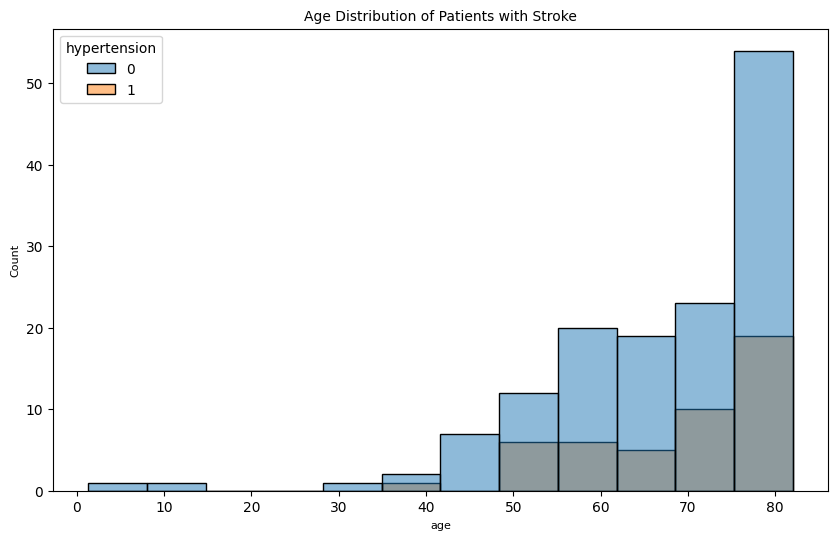

In [23]:
sns.histplot(stroke_patients, x="age", hue="hypertension")
plt.title("Age Distribution of Patients with Stroke")
plt.show()

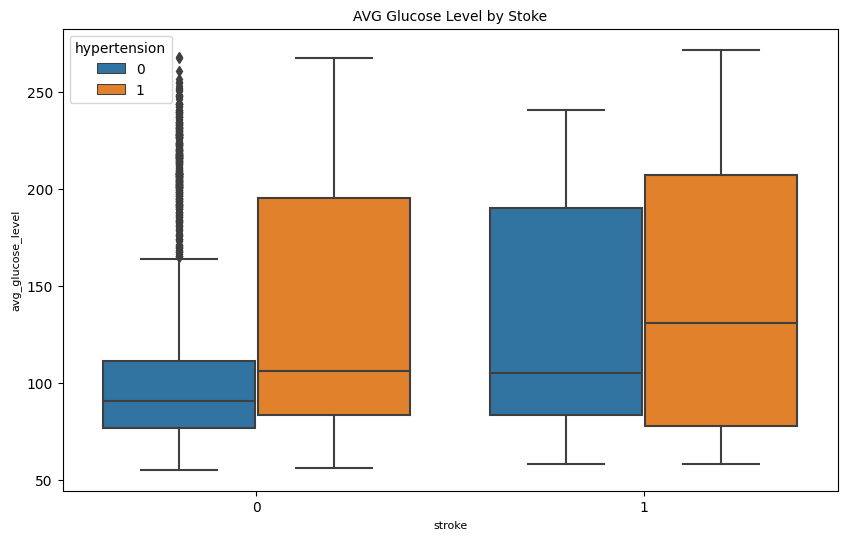

In [24]:
sns.boxplot(X_train, x="stroke", y="avg_glucose_level", hue="hypertension")
plt.title("AVG Glucose Level by Stoke")
plt.show()

- We observe Too many outliers for Non-Stroke Patients with diabetes

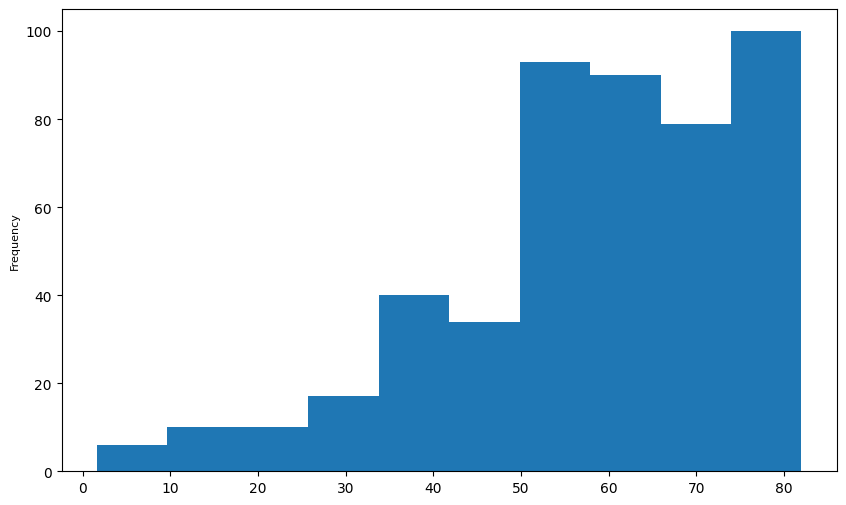

In [25]:
# let's plot distribution of patients with no stroke to understand the ouliers properly

no_hp = X_train[(X_train["stroke"] == 0) & (X_train["avg_glucose_level"] > 160)]
no_hp.age.plot(kind="hist")
plt.show()

In [26]:
X_train.shape

(4088, 12)

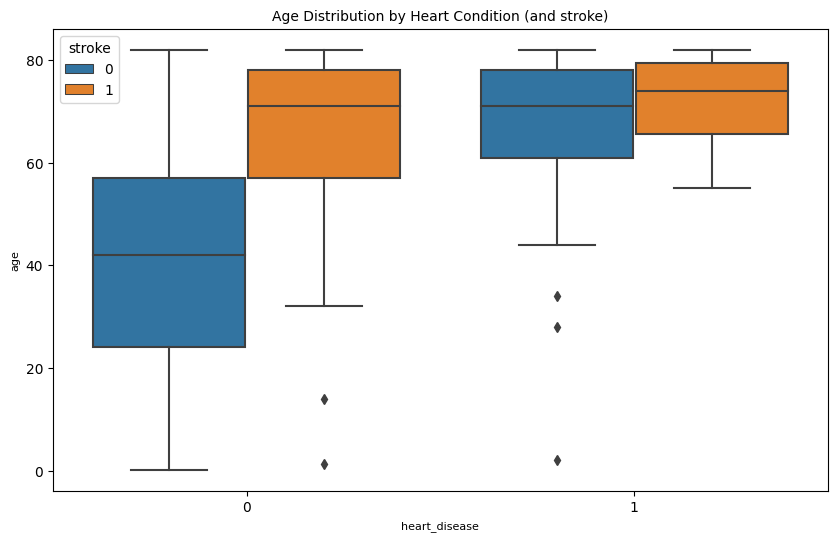

In [27]:
sns.boxplot(X_train, x="heart_disease", y="age", hue="stroke")
plt.title("Age Distribution by Heart Condition (and stroke)")
plt.show()

- We notice that older people on average have a much higher chance of having a heart defect